# Import Libraries



In [119]:
#!pip install --upgrade xgboost
#!pip install --upgrade scikit-learn
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,OrdinalEncoder
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Load datasets

In [120]:
train_df = pd.read_csv('aug_train.csv')
test_df = pd.read_csv('aug_test.csv')

# Data Cleaning

In [121]:
# Handling datatype

train_df['city_development_index'] = train_df['city_development_index'] * 100
test_df['city_development_index'] = test_df['city_development_index'] * 100

test_df['city'] = test_df['city'].astype(str)
train_df['city'] = train_df['city'].astype(str)

test_df['company_size'] = test_df['company_size'].astype(str)
train_df['company_size'] = train_df['company_size'].astype(str)

train_df['experience'] = train_df['experience'].replace({'>20': '21', '<1': '0'}).astype(float)
test_df['experience'] = test_df['experience'].replace({'>20': '21', '<1': '0'}).astype(float)

train_df['company_size'] = train_df['company_size'].replace({'<10':'Emerging_TinyScale','50-99':'TinyScale','100-500':'SmallScale',
                                                             '500-999':'Intermediate-MediumScale','1000-4999':'MediumScale',
                                                             '5000-9999':'LargeScale', '10000+': 'Corporate', '10/49': 'Emerging_SmallScale'})
test_df['company_size'] = test_df['company_size'].replace({'<10':'Emerging_TinyScale','50-99':'TinyScale','100-500':'SmallScale',
                                                             '500-999':'Intermediate-MediumScale','1000-4999':'MediumScale',
                                                             '5000-9999':'LargeScale', '10000+': 'Corporate', '10/49': 'Emerging_SmallScale'})

train_df['last_new_job'] = train_df['last_new_job'].replace({'>4': '5', 'never':'0'}).astype(float)
test_df['last_new_job'] = test_df['last_new_job'].replace({'>4': '5','never':'0' }).astype(float)

# Data Visualization



In [122]:
def descriptive_statistics(df):
    print("Numerical Columns Statistics:")
    print(df.describe())
    print("\nCategorical Columns Statistics:")
    print(df.describe(include=['object']))

descriptive_statistics(train_df)
descriptive_statistics(test_df)

Numerical Columns Statistics:
        enrollee_id  city_development_index    experience  last_new_job  \
count  19158.000000            19158.000000  19093.000000  18735.000000   
mean   16875.358179               82.884800     10.100141      2.000427   
std     9616.292592               12.336176      6.777024      1.675596   
min        1.000000               44.800000      0.000000      0.000000   
25%     8554.250000               74.000000      4.000000      1.000000   
50%    16982.500000               90.300000      9.000000      1.000000   
75%    25169.750000               92.000000     16.000000      3.000000   
max    33380.000000               94.900000     21.000000      5.000000   

       training_hours        target  
count    19158.000000  19158.000000  
mean        65.366896      0.249348  
std         60.058462      0.432647  
min          1.000000      0.000000  
25%         23.000000      0.000000  
50%         47.000000      0.000000  
75%         88.000000      0

In [123]:
# Checking for null values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()
missing_percent_train = (missing_values_train / len(train_df)) * 100
print("Missing Values in Train Dataset:\n")
for col, missing_count in missing_values_train.items():
    missing_percent = missing_percent_train[col]
    print(f"{col}: {missing_count} ({missing_percent:.2f}%)")
print("\nMissing Values in Test Dataset:")
print(missing_values_test)


Missing Values in Train Dataset:

enrollee_id: 0 (0.00%)
city: 0 (0.00%)
city_development_index: 0 (0.00%)
gender: 4508 (23.53%)
relevent_experience: 0 (0.00%)
enrolled_university: 386 (2.01%)
education_level: 460 (2.40%)
major_discipline: 2813 (14.68%)
experience: 65 (0.34%)
company_size: 0 (0.00%)
company_type: 6140 (32.05%)
last_new_job: 423 (2.21%)
training_hours: 0 (0.00%)
target: 0 (0.00%)

Missing Values in Test Dataset:
enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size                0
company_type              634
last_new_job               40
training_hours              0
dtype: int64


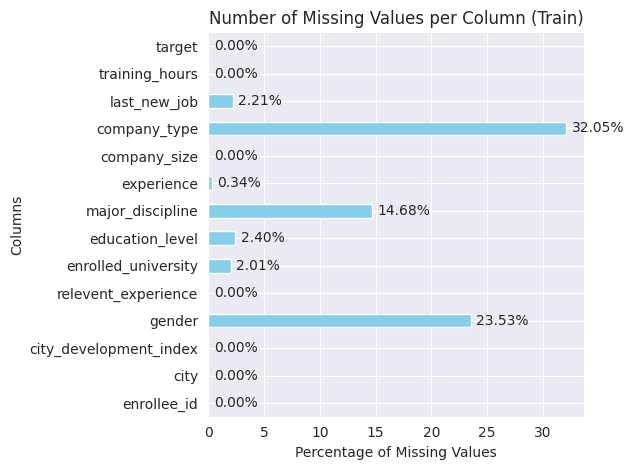

In [124]:
# Visualizing missing values
# Plot the missing values
ax = missing_percent_train.plot.barh(color='skyblue')

# Add percentage labels at the end of each bar
for index, value in enumerate(missing_percent_train):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.title('Number of Missing Values per Column (Train)')
plt.ylabel('Columns')
plt.xlabel('Percentage of Missing Values')
plt.tight_layout()
plt.show()

## Null Value Treatment

In [125]:

# Columns to fill using mode
columns_mode_fill = ['experience', 'company_type', 'gender', 'major_discipline', 'education_level', 'enrolled_university']
for col in columns_mode_fill:
    train_df[col].dropna(train_df[col].mode()[0], inplace=True)

# Fill 'last_new_job' using probability distribution (excluding '1')
job_dist = train_df[train_df['last_new_job'].notnull() & (train_df['last_new_job'] != 1)]['last_new_job'].value_counts(normalize=True)
train_df.loc[train_df['last_new_job'].isnull(), 'last_new_job'] = np.random.choice(
    job_dist.index,
    size=train_df['last_new_job'].isnull().sum(),
    p=job_dist.values
)

# Fill 'company_size' using weighted random sampling
valid_categories = ['TinyScale', 'SmallScale', 'Corporate', 'Emerging_SmallScale',
                    'MediumScale', 'Emerging_TinyScale', 'Intermediate-MediumScale', 'LargeScale']
probabilities = [0.34, 0.28, 0.17, 0.10, 0.05, 0.04, 0.02, 0.01]  # Adjusted based on category distribution

# Normalize probabilities to ensure they sum to 1
probabilities = np.array(probabilities)  # Convert to NumPy array for easier calculations
probabilities /= probabilities.sum()  # Normalize by dividing by the sum

train_df.loc[train_df['company_size'].isnull(), 'company_size'] = np.random.choice(
    valid_categories,
    size=train_df['company_size'].isnull().sum(),
    p=probabilities
)

In [126]:
train_df = train_df.drop(columns=[ 'enrollee_id'], errors='ignore')
test_df = test_df.drop(columns=[ 'enrollee_id '], errors='ignore')

# Cleaned Datasets

In [127]:
# Save cleaned datasets
train_df.to_csv('cleaned_train.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)



# Exploratory Data Analysis (EDA)

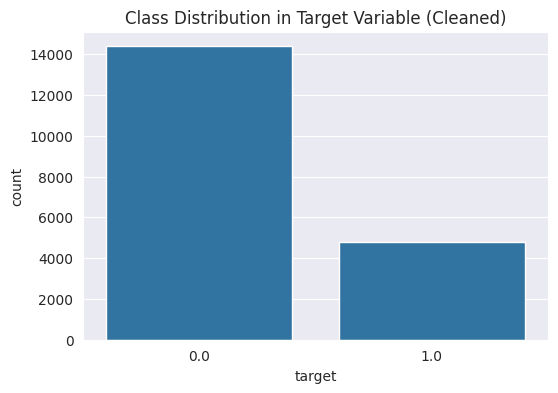

In [128]:
# Check Data Imbalance using cleaned dataset
plt.figure(figsize=(6,4))
sns.countplot(x=train_df['target'])
plt.title('Class Distribution in Target Variable (Cleaned)')
plt.show()



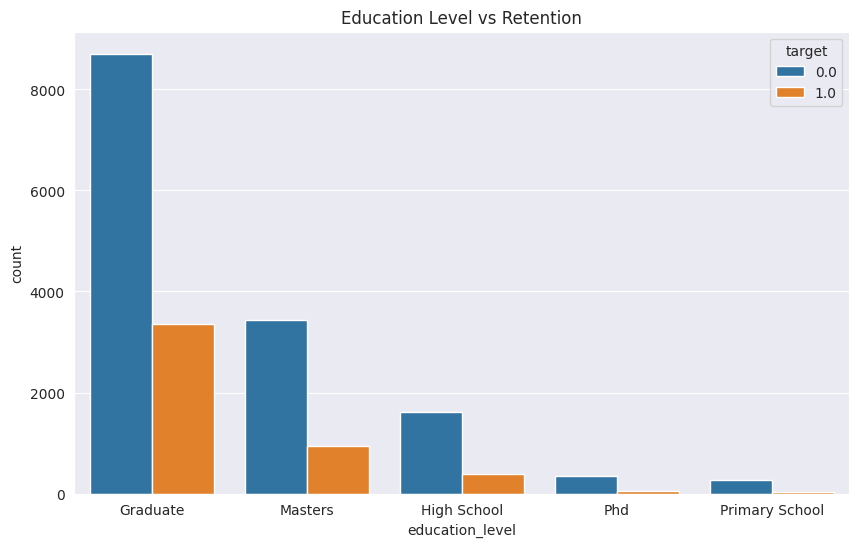

In [129]:
# Data Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='education_level', hue='target')
plt.title('Education Level vs Retention')
plt.show()



<Axes: xlabel='education_level', ylabel='count'>

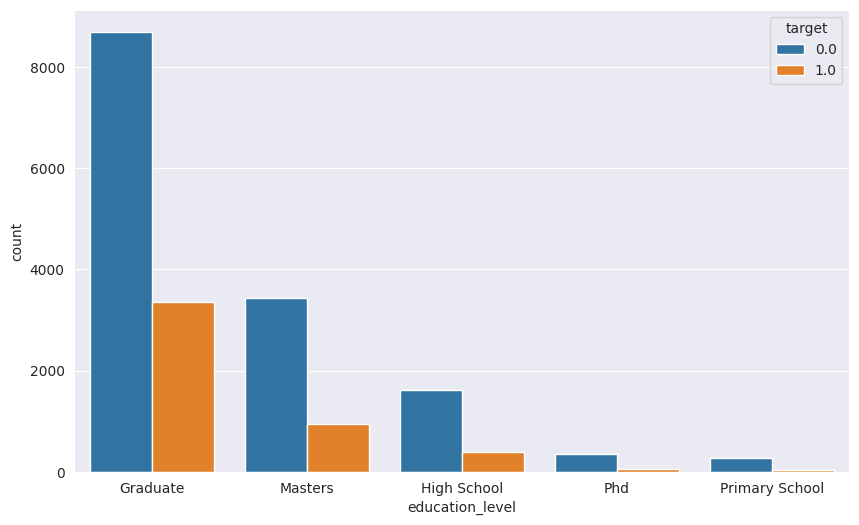

In [130]:
# Data Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='education_level', hue='target')



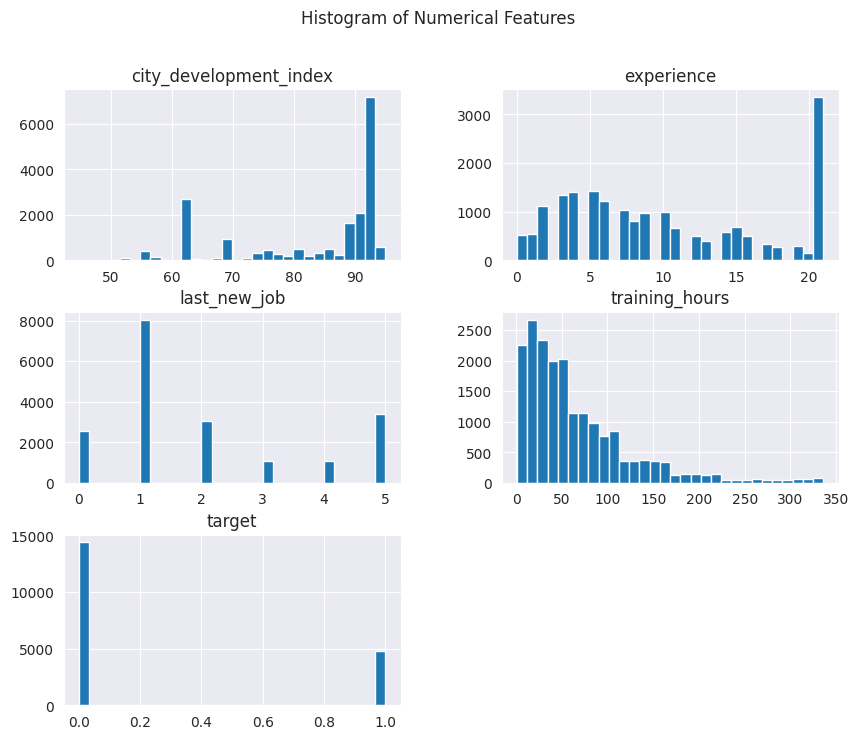

In [131]:
# Histogram for numerical columns
train_df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Histogram of Numerical Features")
plt.show()



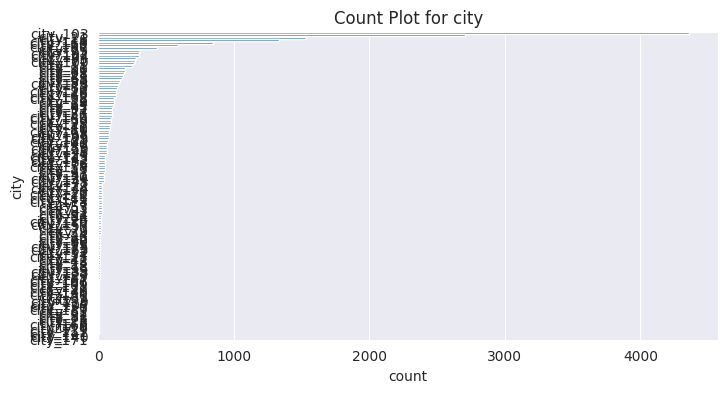

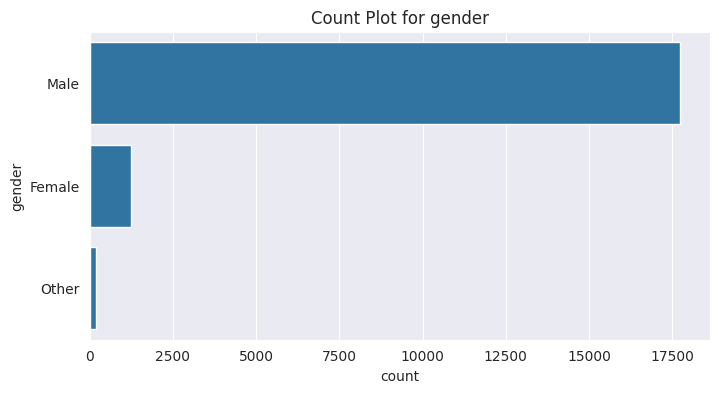

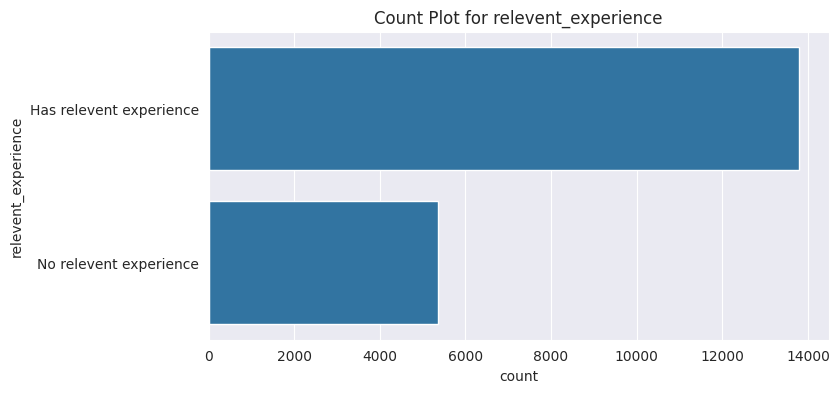

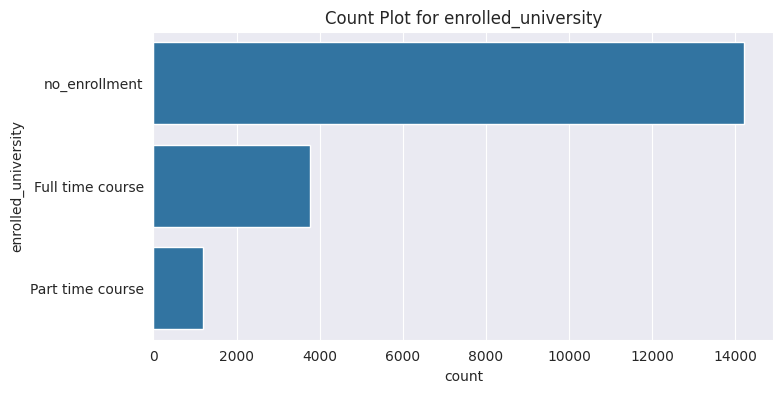

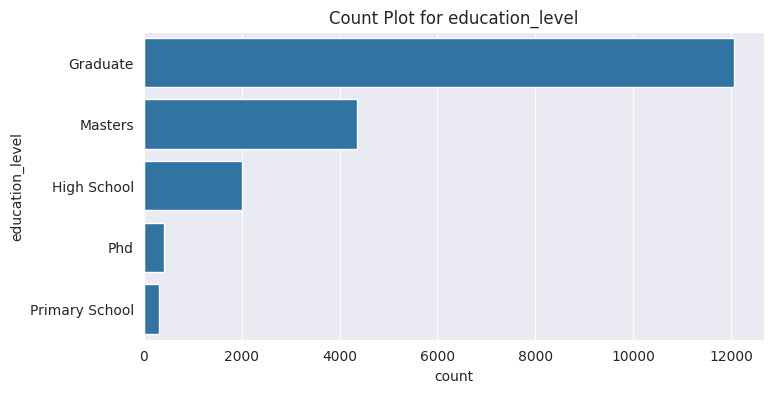

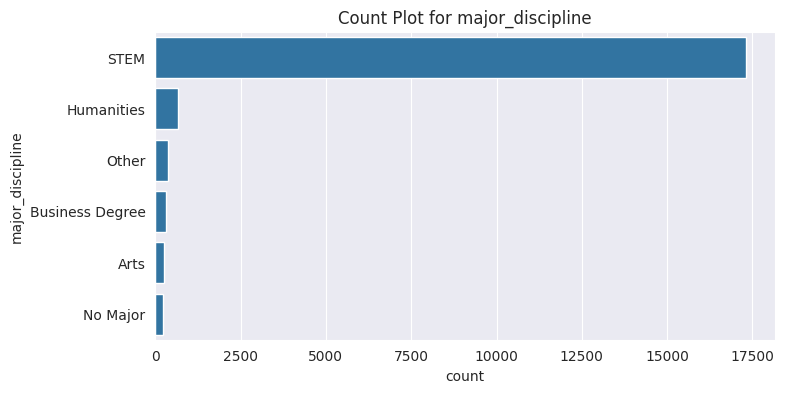

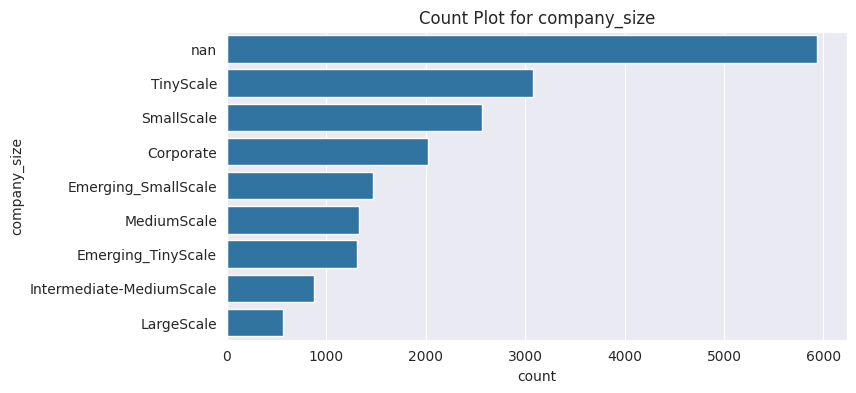

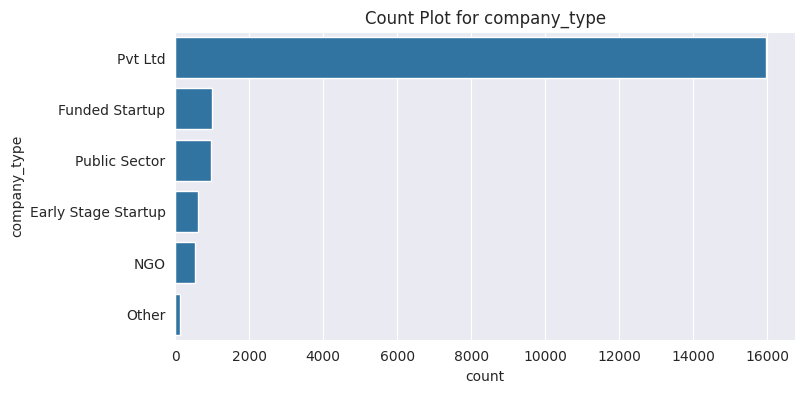

In [132]:
# Count plots for categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index)
    plt.title(f"Count Plot for {col}")
    plt.show()



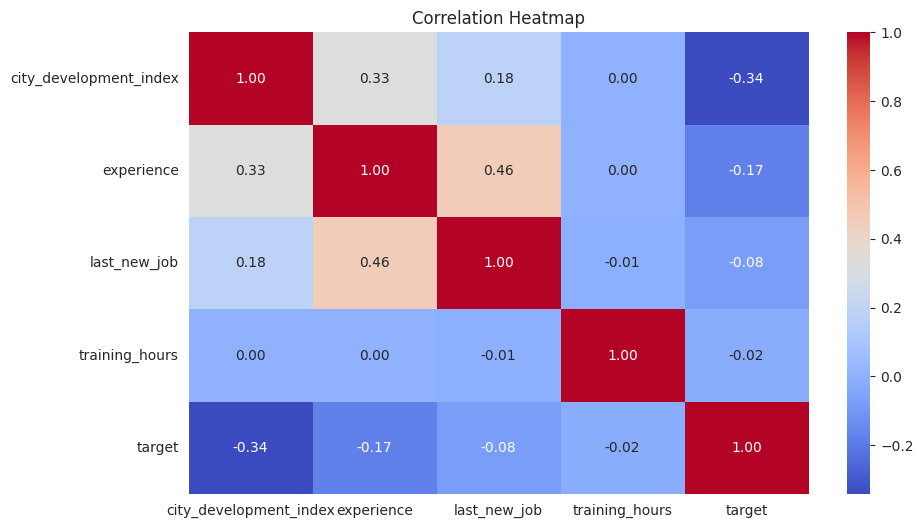

In [133]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
# Select only numerical columns for correlation calculation
numerical_df = train_df.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


In [151]:
#Visualizing categorical feature distributions
categorical_features = train_df.select_dtypes(include=['object']).columns
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=train_df[col], palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

In [152]:
#Correlation of categorical variables with target
def category_target_correlation(df, categorical_cols):
    correlation_dict = {}
    for col in categorical_cols:
        if df[col].nunique() > 1:  # Ensure it's a categorical column
            correlation = df.groupby(col)['target'].mean()
            correlation_dict[col] = correlation
    return correlation_dict

correlations = category_target_correlation(train_df, categorical_features)

for col, corr in correlations.items():
    plt.figure(figsize=(8, 4))
    sns.barplot(x=corr.index, y=corr.values, palette='coolwarm')
    plt.xticks(rotation=45)
    plt.title(f'Correlation of {col} with Target')
    plt.ylabel('Retention Rate')
    plt.show()

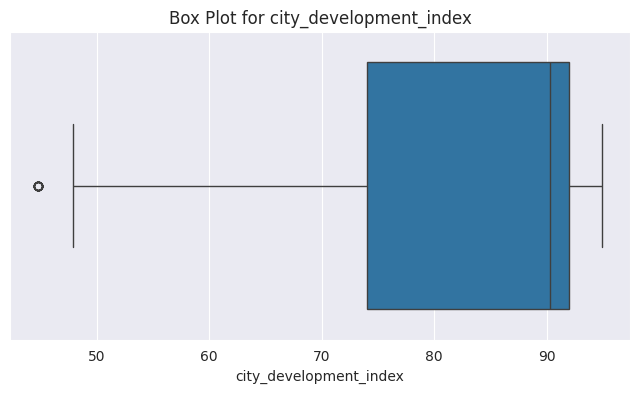

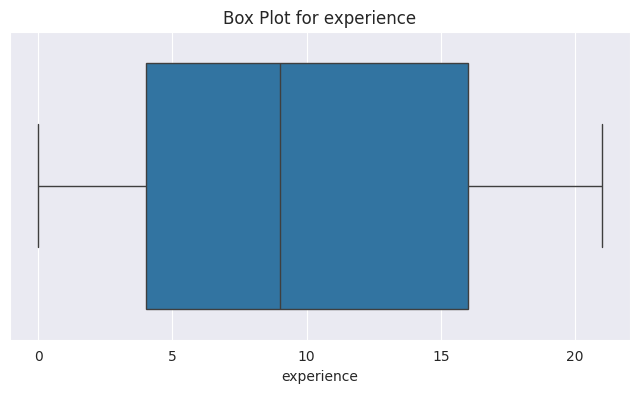

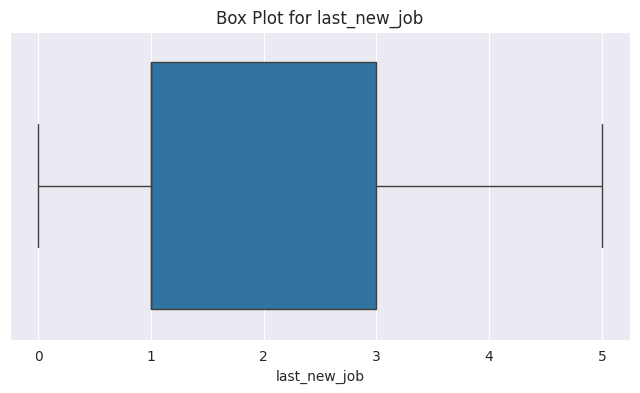

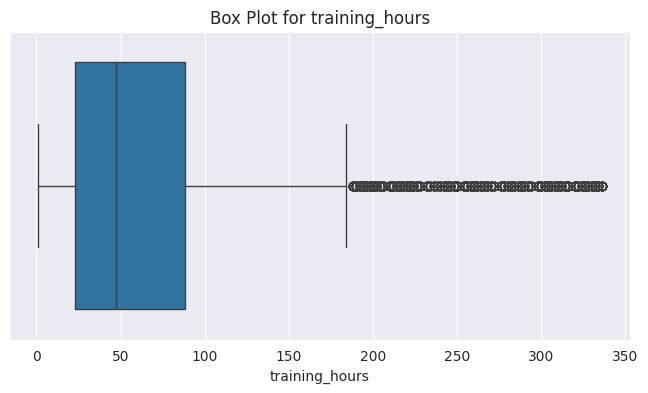

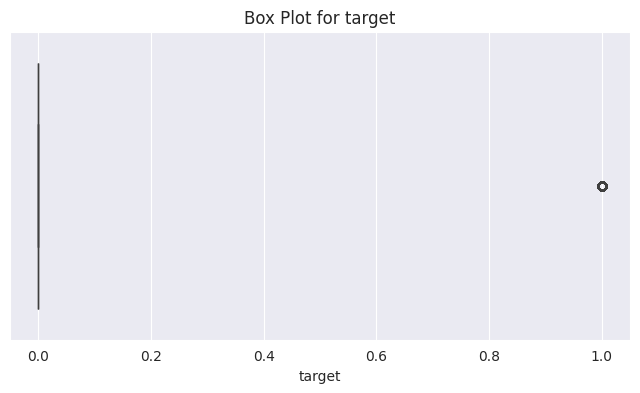

In [136]:
# Box plots for outliers detection
numerical_columns = train_df.select_dtypes(include=['number']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[col])
    plt.title(f"Box Plot for {col}")
    plt.show()

In [137]:
# Outlier Detection using Z-score
from scipy.stats import zscore
train_df_numeric = train_df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(train_df_numeric))
train_df = train_df[(z_scores < 3).all(axis=1)]
print("Shape after removing outliers:", train_df.shape)

Shape after removing outliers: (18691, 13)


In [138]:
# Outlier Detection using Z-score
from scipy.stats import zscore
test_df_numeric = test_df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(test_df_numeric))
test_df = test_df[(z_scores < 3).all(axis=1)]
print("Shape after removing outliers:", test_df.shape)

Shape after removing outliers: (0, 13)


# Outlier Treatment

# Encoding

In [139]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# List of all categorical columns that need encoding
categorical_columns = ['relevent_experience', 'city', 'gender', 'enrolled_university',
                        'major_discipline', 'company_type', 'education_level', 'company_size']

# Apply Label Encoding to both train and test datasets
for col in categorical_columns:
    train_df[col] = le.fit_transform(train_df[col])  # Fit & transform on training data
    test_df[col] = le.transform(test_df[col])  # Transform test data using the same encoder


# Splitting Test & Train

In [140]:
from sklearn.model_selection import train_test_split

# Split train_df into train and validation sets
X = train_df.drop(columns=['target'])
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# X_test remains unchanged (we don't split it further)
X_test = test_df  # No target in test set


In [141]:
# Ensure train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)

# SMOTE - (Synthetic Minority Over-sampling Technique)

In [142]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)




In [143]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [144]:
#Apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit & transform on train data
X_test = scaler.transform(X_test)        # Transform only on test data

# Model Building

In [145]:
# Hyperparameter tuning settings (example parameters, modify as needed)
param_grid = {
    'Random Forest': {
        'n_estimators': [100, 300, 500],  # More trees for better generalization
        'max_depth': [10, 20, 30],  # Deeper trees for learning more complex patterns
        'min_samples_split': [2, 5, 10],  # Prevent overfitting by requiring minimum samples
        'min_samples_leaf': [1, 2, 4],  # Control complexity
        'max_features': ['sqrt', 'log2']  # Try different feature selection methods
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.05, 0.1],  # Lower values for stable learning
        'n_estimators': [100, 300, 500],  # More boosting rounds for better learning
        'max_depth': [3, 6, 9],  # Control complexity
        'subsample': [0.6, 0.8, 1.0],  # Avoid overfitting by using subsets
        'colsample_bytree': [0.6, 0.8, 1.0],  # Feature selection per tree
        'gamma': [0, 0.1, 0.3]  # Pruning parameter to avoid unnecessary splits
    },
    'LightGBM': {
        'learning_rate': [0.01, 0.05, 0.1],  # Smooth learning process
        'n_estimators': [100, 300, 500],  # More boosting rounds
        'num_leaves': [20, 40, 60],  # Control complexity
        'max_depth': [5, 10, 15],  # Prevent overfitting
        'min_data_in_leaf': [10, 20, 30],  # Avoid small leaf nodes
        'feature_fraction': [0.6, 0.8, 1.0]  # Randomly select features for each tree
    }
}



Training Logistic Regression...


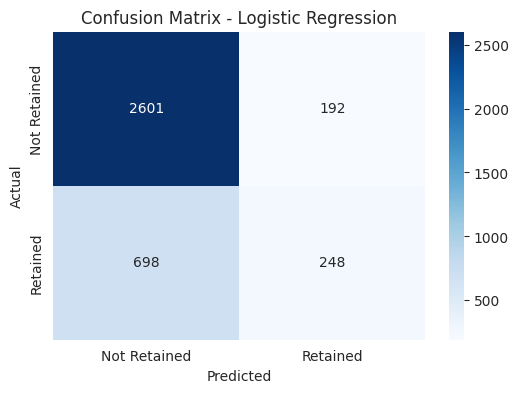

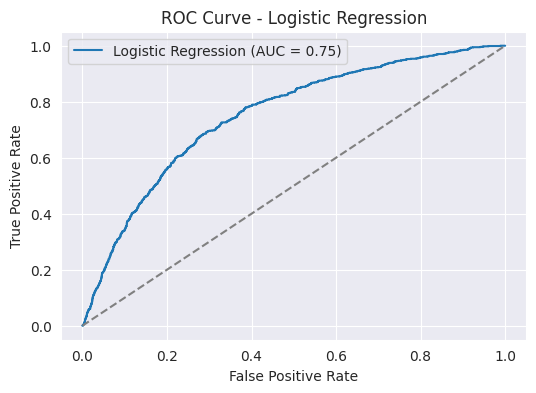

Logistic Regression Accuracy: 0.76, F1 Score: 0.36, Precision: 0.56, AUC: 0.75

Training Decision Tree...


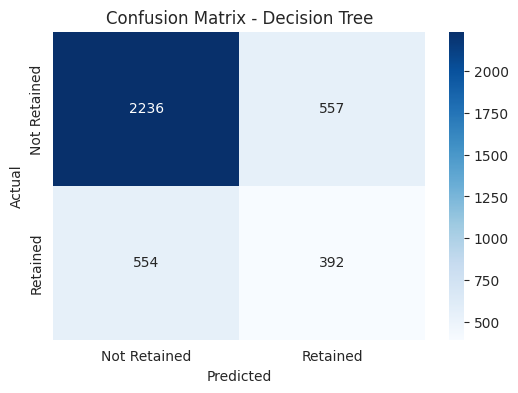

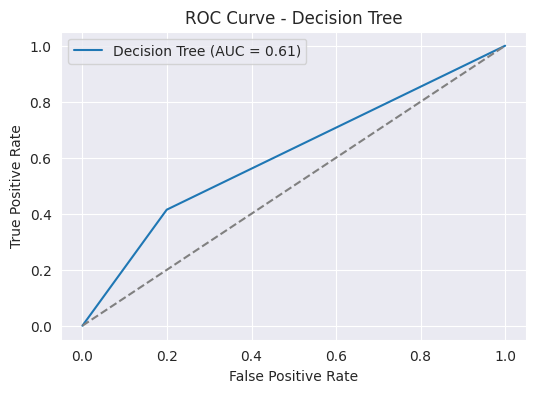

Decision Tree Accuracy: 0.70, F1 Score: 0.41, Precision: 0.41, AUC: 0.61

Training Random Forest...


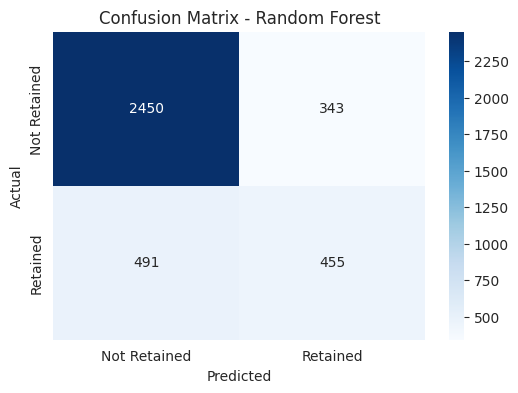

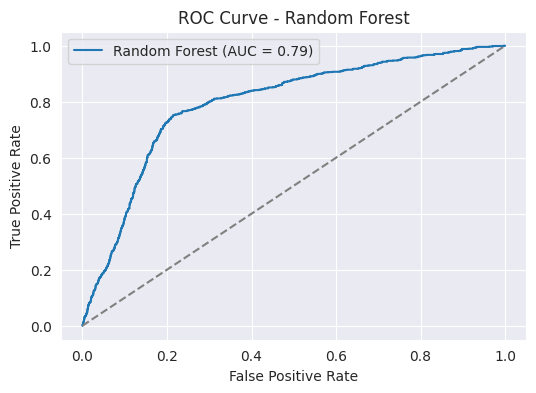

Random Forest Accuracy: 0.78, F1 Score: 0.52, Precision: 0.57, AUC: 0.79

Training XGBoost...


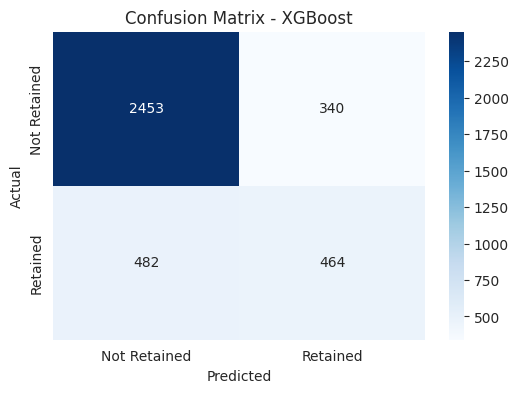

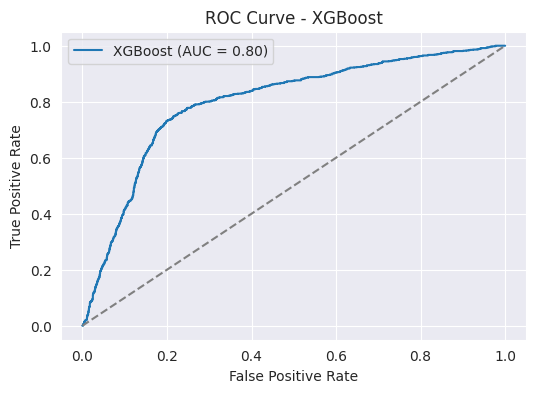

XGBoost Accuracy: 0.78, F1 Score: 0.53, Precision: 0.58, AUC: 0.80

Training LightGBM...
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 2484, number of negative: 7484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 9968, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249197 -> ini

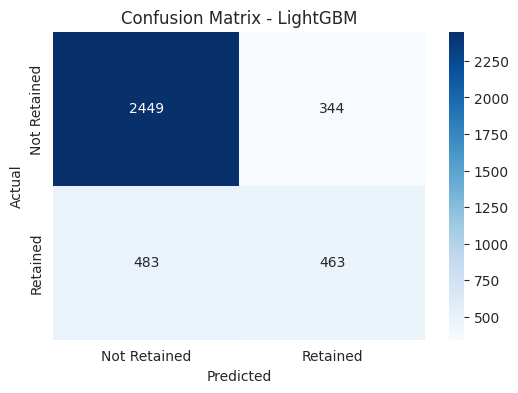

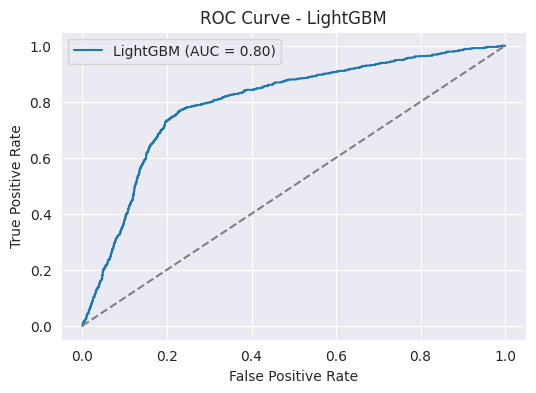

LightGBM Accuracy: 0.78, F1 Score: 0.53, Precision: 0.57, AUC: 0.80


In [146]:
# Building ML Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in param_grid:
        # Use RandomizedSearchCV instead of GridSearchCV if you want to use n_iter
        search = RandomizedSearchCV(model, param_distributions=param_grid[name], cv=3, scoring='accuracy', n_iter=5, random_state=42)
        search.fit(X_train, y_train)
        model = search.best_estimator_
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Retained', 'Retained'], yticklabels=['Not Retained', 'Retained'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve & AUC Score
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc_score = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
    else:
        auc_score = None

    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'AUC': auc_score}
    print(f'{name} Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, AUC: {auc_score:.2f}' if auc_score else f'{name} Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}')


In [147]:
# Display summary results
df_results = pd.DataFrame(results).T
print("\nModel Performance Summary")
print(df_results)


Model Performance Summary
                     Accuracy  F1 Score  Precision       AUC
Logistic Regression  0.761968  0.357864   0.563636  0.751314
Decision Tree        0.702862  0.413720   0.413066  0.607478
Random Forest        0.776946  0.521789   0.570175  0.794340
XGBoost              0.780155  0.530286   0.577114  0.798364
LightGBM             0.778818  0.528237   0.573730  0.795929
